In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models.models import Unet
import cv2
from segmentation_models.utils import predict_big_image
import os
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs_h = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.flip_inputs_w = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
    self.flip_labels_h = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.flip_labels_w = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
    
    self.rotate_inputs = tf.keras.layers.RandomRotation(factor=1., fill_mode='constant', seed=seed)
    self.rotate_labels = tf.keras.layers.RandomRotation(factor=1., fill_mode='constant', seed=seed)

    self.rnd_contrast = tf.keras.layers.RandomContrast(factor=0.05, seed=seed)
    self.rnd_bright = tf.keras.layers.RandomBrightness(factor=0.05, seed=seed)

  def call(self, inputs, labels):

    inputs = self.rotate_inputs(inputs)
    labels = self.rotate_labels(labels)
    inputs = self.rnd_contrast(inputs)
    inputs = self.rnd_bright(inputs)

    return inputs, labels

imdir_train = "./Training/Patch/Images/"
mdir_train = "./Training/Patch/Annotations/"

imdir_val = "./Validazione/Patch/Images/"
mdir_val = "./Validazione/Patch/Annotations/"


train_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir_train,
    labels=None,
    batch_size=8,
    image_size=(384, 384),
    color_mode="rgb",
    seed=42,
)
train_masks = tf.keras.utils.image_dataset_from_directory(
    mdir_train,
    labels=None,
    batch_size=8,
    image_size=(384, 384),
    color_mode="grayscale",
    seed=42,
)
val_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir_val,
    labels=None,
    batch_size=8,
    image_size=(384, 384),
    color_mode="rgb",
    seed=42,
)
val_masks = tf.keras.utils.image_dataset_from_directory(
    mdir_val,
    labels=None,
    batch_size=8,
    image_size=(384, 384),
    color_mode="grayscale",
    seed=42,
)

train_ds = tf.data.Dataset.zip((train_imgs, train_masks))
val_ds = tf.data.Dataset.zip((val_imgs, val_masks))

train_ds = train_ds.map(Augment())

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
LUT = np.zeros(shape=(7,3), dtype=np.uint8)

LUT[0] = [0, 0, 0]          # Background
LUT[1] = [244, 229, 136]    # WDF
LUT[2] = [104, 180, 46]     # Swamp
LUT[3] = [42, 75, 155]      # Organic
LUT[4] = [241, 137, 24]     # Sand
LUT[5] = [128, 192, 123]    # PDF
LUT[6] = [106, 69, 149]     # ProDelta

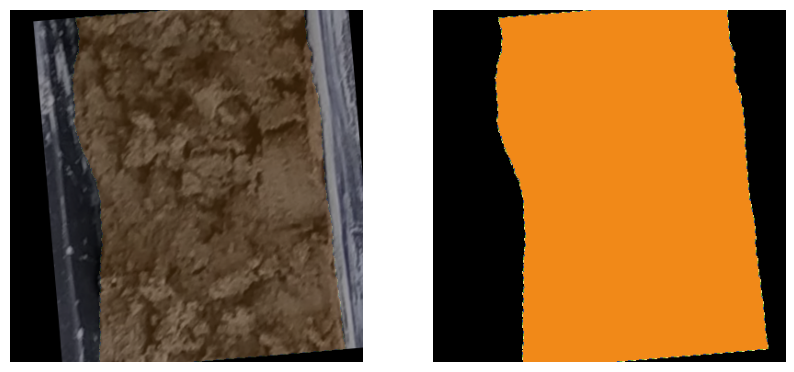

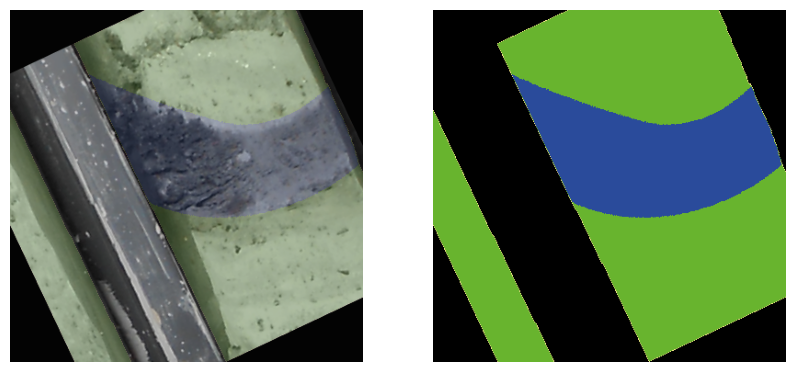

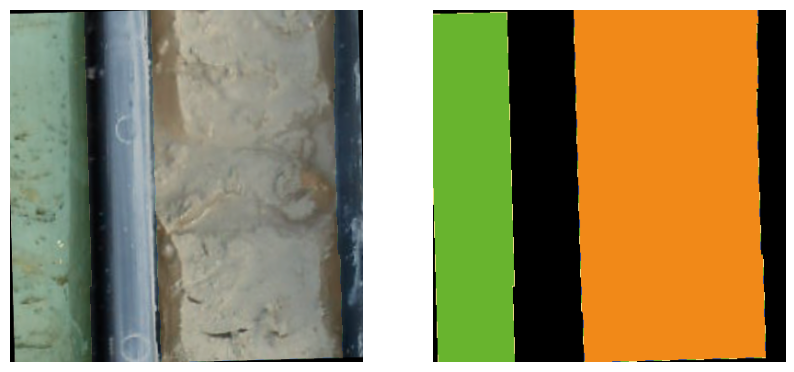

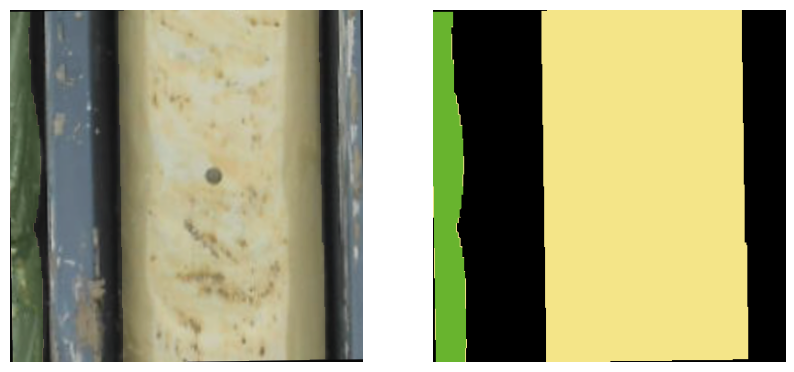

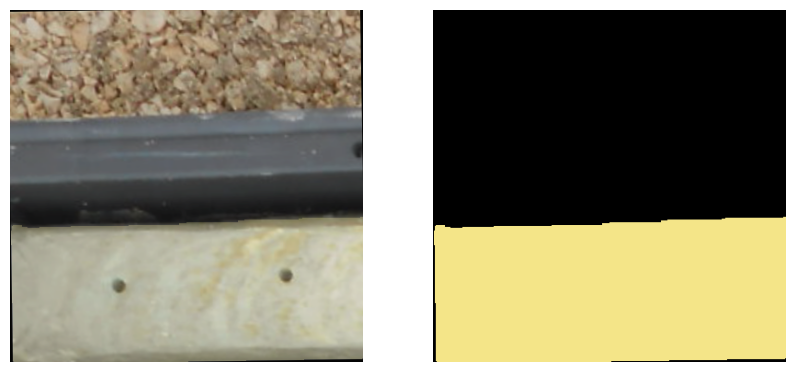

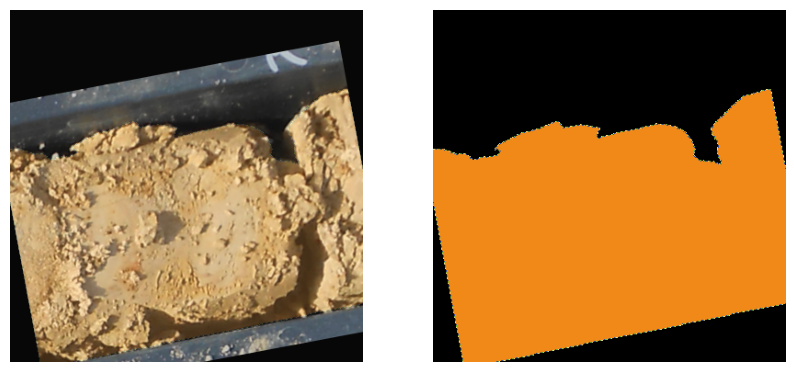

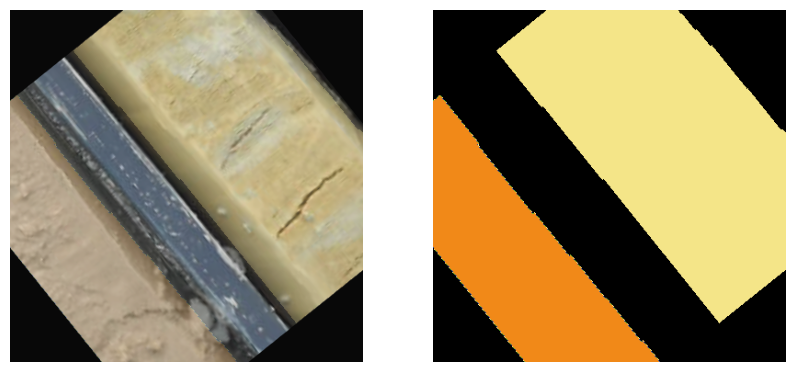

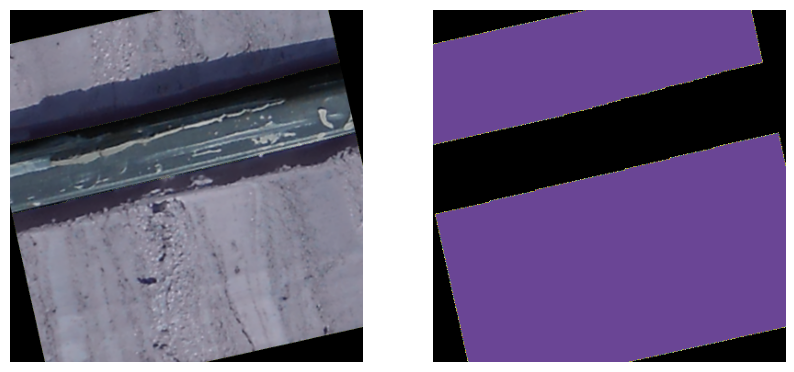

In [5]:
for img, mask in train_ds.take(1):

    for i in range(8):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
        ax1.imshow(img[i].numpy().astype(np.uint8))
        ax2.imshow(LUT[mask[i].numpy().astype('uint8')[..., 0]])
        ax1.imshow(LUT[mask[i].numpy().astype('uint8')[..., 0]], alpha=0.2)
        ax1.axis('off') ; ax2.axis('off')

In [9]:
EPOCHS = 100
starter_learning_rate = 1e-4
end_learning_rate = 5e-6
decay_steps = train_ds.cardinality().numpy() * EPOCHS
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

In [11]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=True,
    monitor='val_my_mean_iou',
    mode='max',
    save_best_only=True)

In [10]:
model = Unet((384, 384, 3), backbone="efficientnetb3", classes=7, final_activation='softmax')

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate_fn,
        name="Adam",
        
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[MyMeanIOU(num_classes=7)]
)

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[model_checkpoint_callback])

In [15]:
hist = pd.DataFrame.from_dict(history.history)
hist.to_csv('history_effnetb3.csv', index=False)

In [ ]:
for img, gt in val_ds.take(1):

    pred = model.predict(img)

    for i in range(4):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))
        ax1.imshow(img[i].numpy().astype('uint8'))
        ax2.imshow(LUT[np.argmax(pred[i], axis=-1).astype('uint8')])
        ax3.imshow(LUT[gt[i].numpy().astype('uint8')[..., 0]])
        ax1.axis('off') ; ax2.axis('off'); ax3.axis('off')

In [11]:
model.load_weights('best_model.h5')

In [12]:
def quantization(img, palette):

    distance = np.linalg.norm(img[:, :, None] - palette[None, None, :], axis=3)

    quantized = np.argmin(distance, axis=2).astype("uint8")

    return quantized


palette = np.array(
    [
        [29, 29, 27],       # Background
        [244, 229, 136],    # WDF
        [104, 180, 46],     # Swamp
        [42, 75, 155],      # Organic
        [241, 137, 24],     # Sand
        [128, 192, 123],    # PDF
        [106, 69, 149]      # ProDelta
    ]
)

In [ ]:
####################
#  PREDICT IMAGES  #
####################

PATH_IMG = "./"
PATH_MASK = "./"

imgs = os.listdir(PATH_IMG)
masks = os.listdir(PATH_MASK)

fig = plt.figure(figsize=(len(imgs) * 10, 30))

i = 1

target_h = 1538
target_w = 3074

for img, mask in zip(imgs, masks):

    im = cv2.imread(os.path.join(PATH_IMG, img))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(os.path.join(PATH_MASK, mask))
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    h, w, _ = im.shape

    im = np.expand_dims(im, axis=0)
    gt = np.expand_dims(gt, axis=0)

    method = "bilinear" if h < target_h else "area"

    im = tf.image.resize_with_pad(
        im, target_height=target_h, target_width=target_w, method=method, antialias=True
    )
    gt = tf.image.resize_with_pad(
        gt, target_height=target_h, target_width=target_w, method="nearest"
    )

    im = im.numpy().squeeze()
    gt = gt.numpy().squeeze()

    im = im[1:-1, 1:-1]
    gt = gt[1:-1, 1:-1]

    quant_gt = quantization(gt, palette=palette)

    pred = predict_big_image(
        img=im,
        model=model,
        patch_size=384,
        stride=96,
        pad=False,
        classes=7,
        batch_size=8,
    )

    ax = fig.add_subplot(len(imgs), 3, i + 0)
    ax.imshow(im.astype("uint8"))
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 3, i + 1)
    ax.imshow(LUT[np.argmax(pred, axis=-1).astype("uint8")])
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 3, i + 2)
    ax.imshow(gt.astype("uint8"))
    ax.axis("off")

    i = i + 3

plt.savefig("prediction.svg", bbox_inches="tight")

In [ ]:
#########################################
#  PREDICT IMAGE WITH MODEL CONFIDENCE  #
#########################################

PATH_IMG = "./"
PATH_MASK = "./"

imgs = os.listdir(PATH_IMG)
masks = os.listdir(PATH_MASK)

fig = plt.figure(figsize=(len(imgs) * 10, 40))

i = 1

target_h = 1538
target_w = 3074

for img, mask in zip(imgs, masks):

    im = cv2.imread(os.path.join(PATH_IMG, img))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(os.path.join(PATH_MASK, mask))
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    h, w, _ = im.shape

    im = np.expand_dims(im, axis=0)
    gt = np.expand_dims(gt, axis=0)

    method = "bilinear" if h < target_h else "area"

    im = tf.image.resize_with_pad(
        im, target_height=target_h, target_width=target_w, method=method, antialias=True
    )
    gt = tf.image.resize_with_pad(
        gt, target_height=target_h, target_width=target_w, method="nearest"
    )

    im = im.numpy().squeeze()
    gt = gt.numpy().squeeze()

    im = im[1:-1, 1:-1]
    gt = gt[1:-1, 1:-1]

    quant_gt = quantization(gt, palette=palette)

    pred = predict_big_image(
        img=im,
        model=model,
        patch_size=384,
        stride=96,
        pad=False,
        classes=7,
        batch_size=8,
    )

    ax = fig.add_subplot(len(imgs), 4, i + 0)
    ax.imshow(im.astype("uint8"))
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 4, i + 1)
    ax.imshow(LUT[np.argmax(pred, axis=-1).astype("uint8")])
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 4, i + 2)
    ax.imshow(gt.astype("uint8"))
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 4, i + 3)
    uncertainty = np.max(pred, axis=-1)
    uncertainty /= np.max(uncertainty)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    im = ax.imshow(
        uncertainty, cmap="afmhot", vmin=uncertainty.min(), vmax=uncertainty.max()
    )

    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.axis("off")

    i = i + 4

plt.savefig("uncertainty.svg", bbox_inches="tight")


In [ ]:
######################################
#   PREDICT IMAGE WITH MODEL ERROR   #
######################################

PATH_IMG = "./"
PATH_MASK = "./"

imgs = os.listdir(PATH_IMG)
masks = os.listdir(PATH_MASK)

fig = plt.figure(figsize=(len(imgs) * 10, 40))

i = 1

target_h = 1538
target_w = 3074

for img, mask in zip(imgs, masks):

    im = cv2.imread(os.path.join(PATH_IMG, img))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(os.path.join(PATH_MASK, mask))
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    h, w, _ = im.shape

    im = np.expand_dims(im, axis=0)
    gt = np.expand_dims(gt, axis=0)

    method = "bilinear" if h < target_h else "area"

    im = tf.image.resize_with_pad(
        im, target_height=target_h, target_width=target_w, method=method, antialias=True
    )
    gt = tf.image.resize_with_pad(
        gt, target_height=target_h, target_width=target_w, method="nearest"
    )

    im = im.numpy().squeeze()
    gt = gt.numpy().squeeze()

    im = im[1:-1, 1:-1]
    gt = gt[1:-1, 1:-1]

    quant_gt = quantization(gt, palette=palette)
    quant_one_hot = tf.one_hot(quant_gt, depth=7)

    pred = predict_big_image(
        img=im,
        model=model,
        patch_size=384,
        stride=96,
        pad=False,
        classes=7,
        batch_size=8,
    )

    ax = fig.add_subplot(len(imgs), 4, i + 0)
    ax.imshow(im.astype("uint8"), alpha=1)
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 4, i + 1)
    ax.imshow(LUT[np.argmax(pred, axis=-1).astype("uint8")])
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 4, i + 2)
    ax.imshow(gt.astype("uint8"))
    ax.axis("off")
    ax = fig.add_subplot(len(imgs), 4, i + 3)
    error = tf.keras.metrics.categorical_crossentropy(quant_one_hot, pred)
    error = error.numpy()
    error /= np.max(error)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    im = ax.imshow(error, cmap="afmhot", vmin=error.min(), vmax=error.max())

    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.axis("off")

    i = i + 4

plt.savefig("error.svg", bbox_inches="tight")
